# Respiratory classification (chest vs. O2 vs. CO2)

**Goal:** build a 3-class classifier based on time-domain features.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text

from physclass.signal import crop_signal, normalize_signal, butter_lowpass, butter_lowpass_filter

**Load data**

In [3]:
df_lab = pd.read_csv('../data/raw/labels.csv')
df = pd.read_csv('../data/raw/time_series.csv')

In [8]:
# select respiratory signals only
is_respiratory = df_lab['label'].isin(['respiratory_chest','respiratory_O2', 'respiratory_CO2'])

TS = df.iloc[:, is_respiratory.tolist()].T
Y = df_lab['label'][is_respiratory]

n_ts = np.count_nonzero(is_respiratory)
ts = 1/df_lab['sampling_freq'][0]
n_samp = df.shape[0]

In [9]:
TS.shape

(181, 17299)

**Processing pipeline (1 signal)**

2001
2001
2001


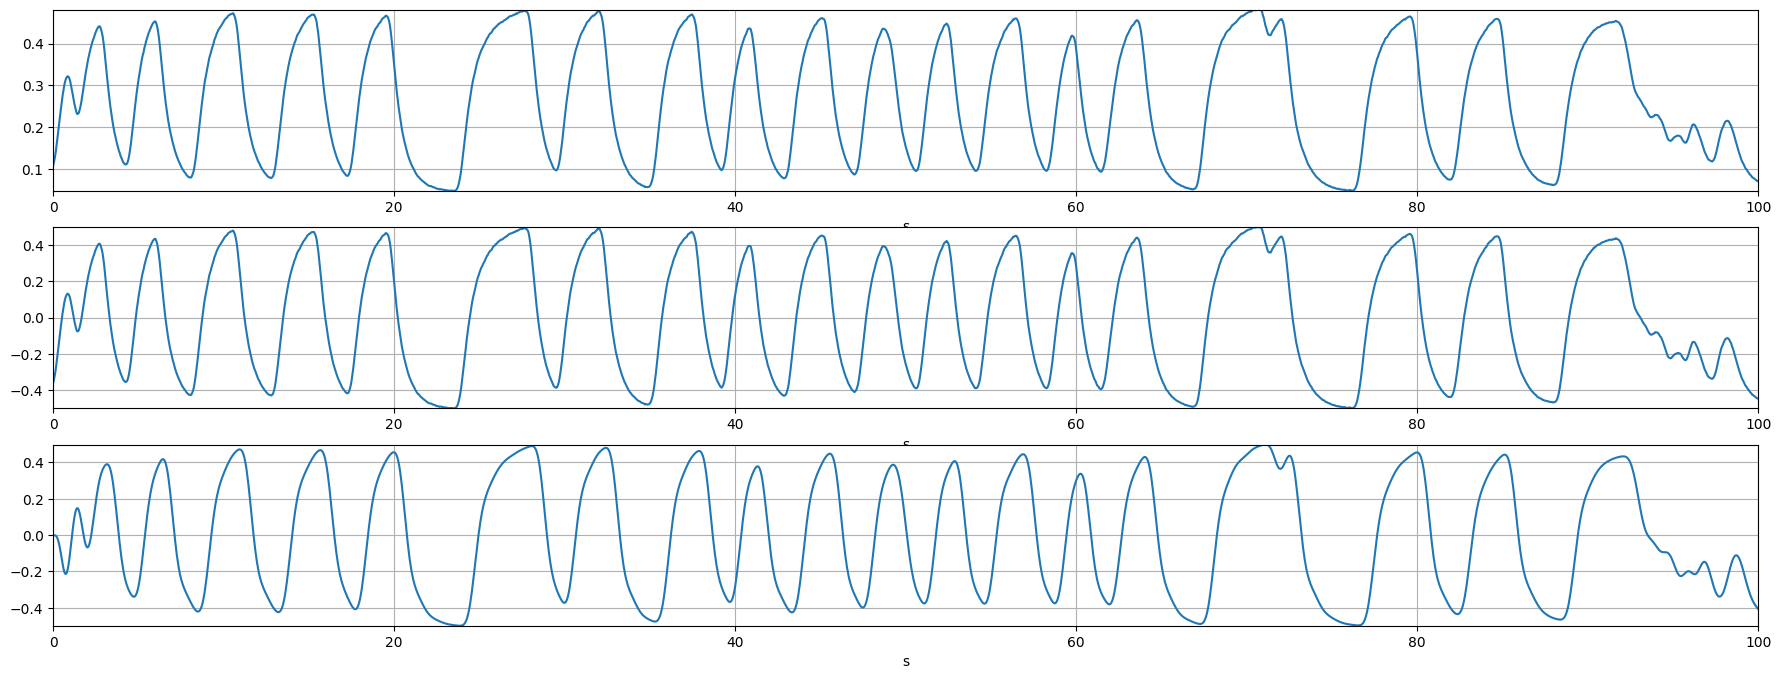

In [16]:
i_ts = 4
t = ts * np.arange(0,n_samp)
s = TS.iloc[i_ts,:]

# Crop signal
tw, s_crop = crop_signal(t, s, 0, 100)

# Normalization
s_norm = normalize_signal(s_crop)

# Smoothing (filtering) use frequency cutoffs from exploratory data analysis
s_filt = butter_lowpass_filter(s_norm, cutoff=1, fs=1/ts, order=5)

fig, ax = plt.subplots(3, 1, figsize=(22, 8))
for i, sp in enumerate([s_crop, s_norm, s_filt]):   
    ax[i].plot(tw, sp)
    ax[i].set_xlim([0, tw.max()])
    ax[i].set_ylim([sp.min(), sp.max()])
    ax[i].grid()
    ax[i].set_xlabel('s')

Text(0.5, 0, 's')

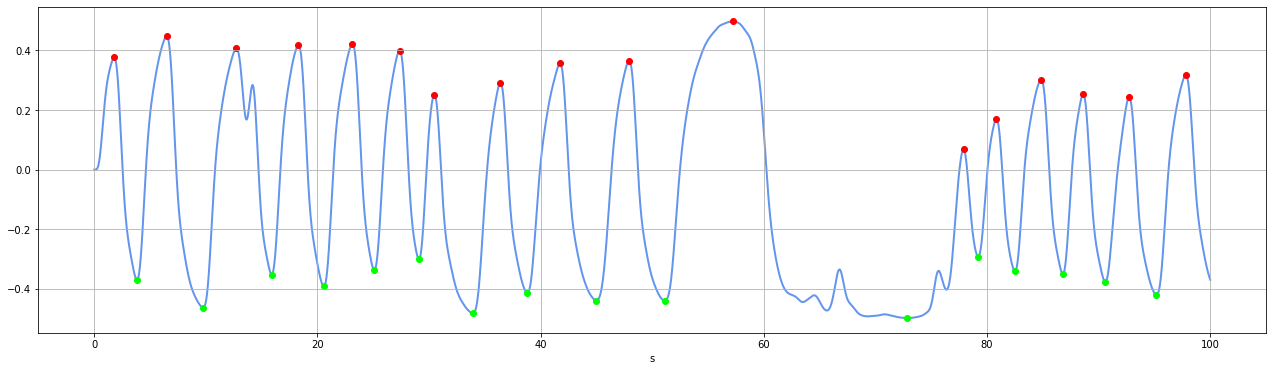

In [ ]:
# Local maxima, minima location
maxima, prop = find_peaks(s_filt, prominence = 0.2)
minima, prop = find_peaks(-s_filt, prominence = 0.2)

fig, ax = plt.subplots(1, 1, figsize=(22, 6))
ax.plot(tw, s_filt, linewidth=2, color='cornflowerblue', zorder=-1)
ax.scatter(tw[maxima], s_filt[maxima], color='red')
ax.scatter(tw[minima], s_filt[minima], color='lime')
ax.grid()
ax.set_xlabel('s')

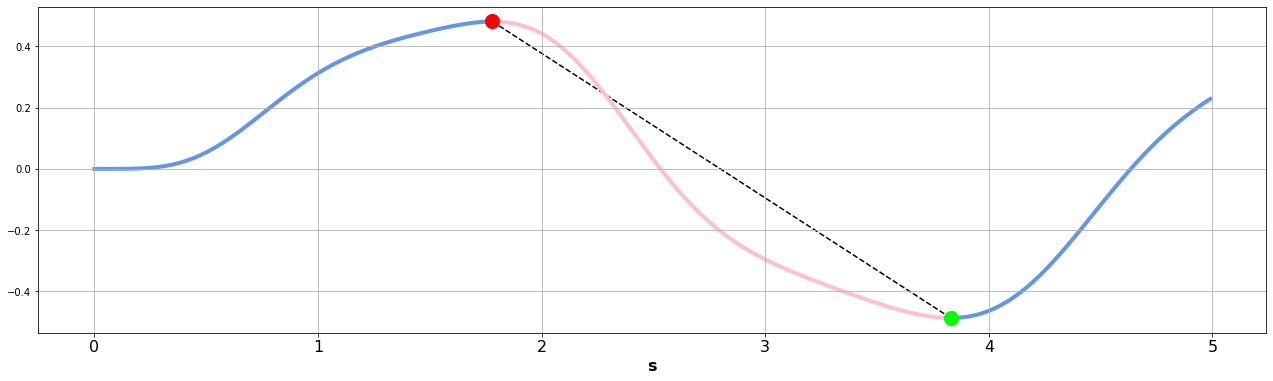

In [106]:
i_ts = 1
t = ts * np.arange(0,n_samp)
s = TS.iloc[i_ts,:]

tw, s_crop = crop_signal(t, s, 0, 5)
s_norm = (s_crop - np.min(s_crop))/(np.max(s_crop) - np.min(s_crop)) - 0.5
b, a = butter_lowpass(cutoff=1, fs=1/ts, order=5)
s_filt = lfilter(b, a, s_norm)
maxima, _ = find_peaks(s_filt, prominence = 0.2)
minima, _ = find_peaks(-s_filt, prominence = 0.2)
fig, ax = plt.subplots(1, 1, figsize=(22, 6))
#ax.plot(tw, s_filt, linewidth=4, color='cornflowerblue', zorder=-1)
ax.plot([tw[maxima[0]], tw[minima[0]]],[s_filt[maxima[0]], s_filt[minima[0]]],color='black',linestyle= 'dashed', zorder=1)
ax.plot(tw[maxima[0]:minima[0]],s_filt[maxima[0]:minima[0]],linewidth = 4, color='pink', zorder=1)
ax.plot(tw[0:maxima[0]],s_filt[0:maxima[0]],color='cornflowerblue', linewidth=4,zorder=1)
ax.plot(tw[minima[0]:-1],s_filt[minima[0]:-1],color='cornflowerblue', linewidth=4,zorder=1)

ax.scatter(tw[maxima], s_filt[maxima], 200, color='red', zorder=2)
ax.scatter(tw[minima], s_filt[minima], 200, color='lime', zorder=2)
ax.grid()
ax.set_xlabel('s',fontsize=16,fontweight='bold')
ax.xaxis.set_tick_params(labelsize=16)

In [ ]:
x1, x2 = compute_time_features(tw, s_filt, minima, maxima)

**Process all signals**

In [ ]:
X1 = np.empty(n_ts)
X2 = np.empty(n_ts)
n_min = np.empty(n_ts)
n_max = np.empty(n_ts)

for i, s in enumerate(TS.to_numpy()):
    # Normalization
    s_norm = normalize_signal(s)

    # Smoothing (filtering) use frequency cutoffs from exploratory data analysis
    s_filt = butter_lowpass_filter(s_norm, cutoff=1, fs=1/ts, order=5)

    # Local minima/maxima location
    maxima, _ = find_peaks(s_filt, prominence = 0.2)
    minima, _ = find_peaks(-s_filt, prominence = 0.2)

    n_max[i] = len(maxima)
    n_min[i] = len(minima)

    # Feature extraction
    X1[i], X2[i] = compute_time_features(t, s, minima, maxima)
  
  # print(f'{i}/{n_ts}')

Check local minima and maxima were located in all signals

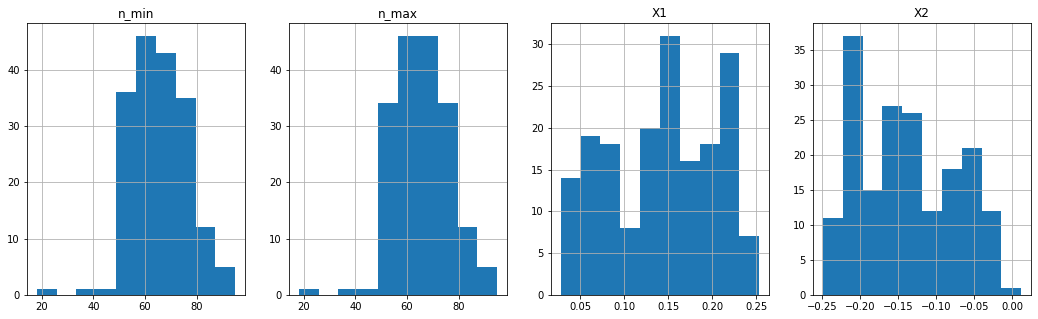

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18,5))

titles = ['n_min', 'n_max', 'X1', 'X2']
for i, x in enumerate([n_min, n_max, X1, X2]):
  axs[i].hist(x)
  axs[i].grid()
  axs[i].set_title(titles[i])

Visualize the features

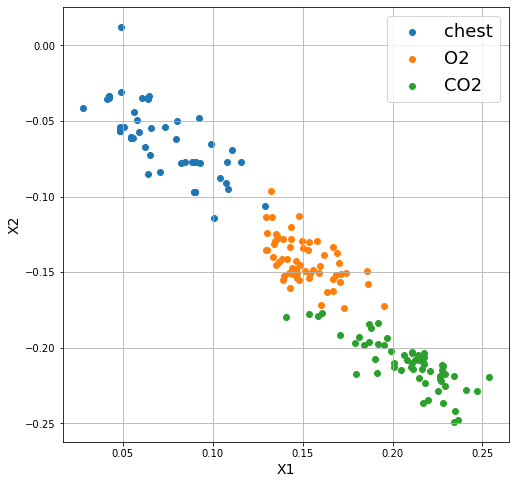

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,8))

ts_types = ['chest', 'O2', 'CO2']
for ts_type in ['respiratory_chest', 'respiratory_O2', 'respiratory_CO2']:
  is_type = Y == ts_type
  axs.scatter(X1[is_type], X2[is_type])
axs.grid()
axs.set_xlabel('X1', fontsize=14)
axs.set_ylabel('X2', fontsize=14)
axs.legend(ts_types, fontsize=18)

**Classification**

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
X = np.column_stack((X1, X2))
acc = np.round(100 * np.mean(cross_val_score(clf, X, Y, cv=10)), 1)
print(f"Mean accuracy: {acc}%")

Mean accuracy: 99.4%


In [ ]:
clf.fit(X, Y)
print(export_text(clf))

|--- feature_1 <= -0.18
|   |--- class: respiratory_CO2
|--- feature_1 >  -0.18
|   |--- feature_0 <= 0.13
|   |   |--- class: respiratory_chest
|   |--- feature_0 >  0.13
|   |   |--- class: respiratory_O2



Visualize the results

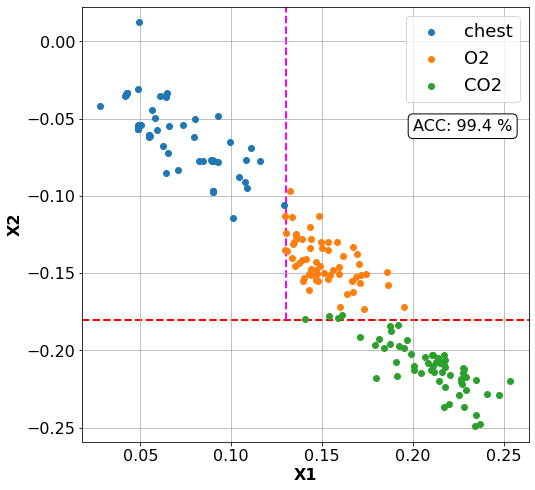

In [ ]:
x2_th = -0.18
x1_th = 0.13

x1_min = np.min(X1) - 0.01
x1_max = np.max(X1) + 0.01
x2_min = np.min(X2) - 0.01
x2_max = np.max(X2) + 0.01

fig, ax = plt.subplots(1, 1, figsize=(8,8))

ts_types = ['chest', 'O2', 'CO2']
for ts_type in ['respiratory_chest', 'respiratory_O2', 'respiratory_CO2']:
    is_type = Y == ts_type
    ax.scatter(X1[is_type], X2[is_type], zorder=2)
ax.legend(ts_types, fontsize=18)

ax.plot([x1_min, x1_max], [x2_th, x2_th], linestyle='dashed', linewidth=2, color = 'red', zorder=1)
ax.plot([x1_th, x1_th], [x2_th, x2_max], linestyle='dashed', linewidth=2, color = 'magenta', zorder=1)
ax.grid()
ax.set_xlabel('X1', fontsize=16, fontweight='bold')
ax.set_ylabel('X2', fontsize=16, fontweight='bold')
ax.set_xlim([x1_min, x1_max])
ax.set_ylim([x2_min, x2_max])
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(0.2, -0.05, f'ACC: {acc} %', fontsize=16,
        verticalalignment='top', bbox=props)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)